# Violent Crime Rate in Canadian Cities and Provinces.
Using 6 different datasets from statistics Canada, We are trying to predict the annual violent crime rate in canadian cities. Datasets used are:
- [Incident-based crime statistics, by detailed violations.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510017701)
- [Low income entry and exit rates of tax filers in Canada.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1110002401)
- [Labour force characteristics by census metropolitan area, annual.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410046101)
- [Summary characteristics of Canadian tax filers preliminary T1 Family File.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1110004701)
- [Consumer Price Index, annual average, not seasonally adjusted.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000501)
- [Police personnel and selected crime statistics, municipal police services](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510007701)

Total violent criminal code violations rate per 100k residents is the target variable. Predictors are:
- Unemployment Rate.
- CPI inflation adjusted income.
- Low income immobility rate.
- Police officers per 100,000 population.

The data is per year per census metro area.

[Github Repo](https://github.com/Bilal1k/Crime)


In [1]:
# Load packages
import requests
import zipfile
import io
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [19]:
# Download, read, preporcess and merge data.
def download_and_extract_csv(url):
    """
    Downloads a ZIP file from the given URL, extracts it,
    and returns the path to the first CSV file that does not contain 'meta' in its name.
    """
    print("Downloading zip file from " + url)
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download file. Status code: {response.status_code}")
    else:
        print("Download Complete")
    # Create a temporary directory
    temp_dir = tempfile.mkdtemp()
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Filter CSV files that do not contain 'meta'
        csv_files = [name for name in z.namelist() if name.endswith('.csv') and 'meta' not in name.lower()]
        
        if not csv_files:
            raise FileNotFoundError("No non-meta CSV files found in the ZIP archive.")
        
        # Extract the first matching CSV file
        csv_name = csv_files[0]
        extracted_path = os.path.join(temp_dir, os.path.basename(csv_name))
        with z.open(csv_name) as source, open(extracted_path, 'wb') as target:
            target.write(source.read())
    
    return extracted_path

def clean_geo_columns(df, city_col='City'):
    # Remove non-Census data
    df = df[~df[city_col].str.contains("Non-Census", na=False)]

    # Split 'City' column into City and Province
    split_cols = df[city_col].str.split(', ', expand=True)
    df['City'] = split_cols[0]
    df['Province'] = split_cols[1] if split_cols.shape[1] > 1 else None

    # Remove [number] suffix from City names
    df['City'] = df['City'].str.replace(r'\s*\[\d+\]', '', regex=True)
    # Split CMA tag if present
    if df['Province'].str.contains(r'\[', na=False).any():
        df[['Province', 'CMA']] = df['Province'].str.split(' \\[', expand=True)
        df['CMA'] = df['CMA'].str.replace(']', '')

    return df

def split_ottawa_gatineau(df):
    # Replace Ottawa-Gatineau with separate rows
    df.loc[(df['City'] == 'Ottawa-Gatineau') & (df["Province"] == 'Ontario part'), 'City'] = 'Ottawa'
    df.loc[(df['City'] == 'Ottawa-Gatineau') & (df["Province"] == 'Quebec part'), 'City'] = 'Gatineau'
    df.loc[df["Province"] == 'Ontario part', 'Province'] = 'Ontario'
    df.loc[df["Province"] == 'Quebec part', 'Province'] = 'Quebec'
    return df[df['City'] != 'Ottawa-Gatineau']

# Filter and save violent crime rate data without fully loading into memory. dataset is 1.7 GB, cannot load into memory.
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/35100177-eng.zip')
output_path = './data/crimeStat/crimeRate.csv'
chunksize = 100_000
first_chunk = True

for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
    filtered_chunk = chunk[
        (chunk['Violations'] == 'Total violent Criminal Code violations [100]') &
        (chunk['Statistics'] == 'Rate per 100,000 population')
    ]
    if not filtered_chunk.empty:
        filtered_chunk.to_csv(output_path, mode='a', index=False, header=first_chunk)
        first_chunk = False

# Load and clean Crime data ---
dfCrime = pd.read_csv(output_path)[["REF_DATE", "GEO", "VALUE"]]
dfCrime.columns = ["Year", "City", "CrimeRate"]

dfCrime = dfCrime[
    (dfCrime["Year"] != "REF_DATE") 
]

dfCrime["Year"] = dfCrime["Year"].astype(int)
dfCrime["CrimeRate"] = pd.to_numeric(dfCrime["CrimeRate"], errors="coerce")
dfCrime = clean_geo_columns(dfCrime)
dfCrime = split_ottawa_gatineau(dfCrime)
dfCrime.dropna(subset=["CrimeRate"], inplace=True)

# Load and clean Unemployment data ---
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/14100461-eng.zip')
dfUnemp = pd.read_csv(file_path)
dfUnemp = dfUnemp[
    (dfUnemp["Labour force characteristics"] == "Unemployment rate") &
    (dfUnemp["Gender"] == "Total - Gender") &
    (dfUnemp["Age group"] == "25 to 54 years")
][["REF_DATE", "GEO", "VALUE"]]
dfUnemp.columns = ["Year", "City", "UnemploymentRate"]
dfUnemp["Year"] = dfUnemp["Year"].astype(int)
dfUnemp = clean_geo_columns(dfUnemp)
dfUnemp = split_ottawa_gatineau(dfUnemp)

# Load and clean Low Income Immobility Rate data ---
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/11100024-eng.zip')
dfMob = pd.read_csv(file_path)
dfMob = dfMob[
    (dfMob["Statistics"] == "Low income immobility rate") &
    (dfMob["Low income threshold"] == "Variable low income measure") &
    (dfMob["Selected characteristics"] == "Both sexes")
]
dfMob[['PrevYear', 'Year']] = dfMob['REF_DATE'].str.split('/', expand=True)
dfMob = dfMob[["Year", "GEO", "VALUE"]]
dfMob.columns = ['Year', 'City', 'lowIncImmobRate']
dfMob["Year"] = dfMob["Year"].astype(int)
dfMob = clean_geo_columns(dfMob)
dfMob = split_ottawa_gatineau(dfMob)

# Load and clean Income and CPI data ---
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/11100047-eng.zip')
dfInc = pd.read_csv(file_path, dtype={'STATUS': str, 'TERMINATED': str})

file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/18100005-eng.zip')
dfCPI = pd.read_csv(file_path)
dfMedInc = dfInc[dfInc["Canadian tax filers"] == "Median employment income of tax filers"]
dfMedInc = dfMedInc[["REF_DATE", "GEO", "VALUE"]]
dfMedInc.columns = ["Year", "City", "MedInc"]
dfMedInc["Year"] = dfMedInc["Year"].astype(int)

dfCPI = dfCPI[dfCPI["Products and product groups"] == "All-items"][["REF_DATE", "VALUE"]]
dfCPI.columns = ["Year", "CPI"]
dfCPI["Year"] = dfCPI["Year"].astype(int)

dfMedInc = pd.merge(dfMedInc, dfCPI, on="Year", how="left")
dfMedInc['MedInc'] = dfMedInc['MedInc'].astype(float)
dfMedInc['CPI'] = dfMedInc['CPI'].astype(float)
dfMedInc = clean_geo_columns(dfMedInc)
dfMedInc = split_ottawa_gatineau(dfMedInc)

# Adjust income for inflation
target_cpi = 160.9 # 2024
dfMedInc['infAdjInc'] = ((dfMedInc['MedInc'] / dfMedInc['CPI']) * target_cpi).round(-2)

# Police officers per 100,000 population
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/35100077-eng.zip')
dfPol = pd.read_csv(file_path)
dfPol = dfPol[
    (dfPol["Statistics"] == "Police officers per 100,000 population") 
]

dfPol["Year"] = dfPol["REF_DATE"].astype(int)
dfPol = dfPol[["Year", "GEO", "VALUE"]]
dfPol.columns = ['Year', 'City', 'policeRate']
dfPol = clean_geo_columns(dfPol)
dfPol.dropna(subset=["policeRate"], inplace=True)

# Merge all data sets ---
df = pd.merge(dfCrime, dfUnemp, on=["Year", "City", "Province"], how="left")
df = pd.merge(df, dfMob, on=["Year", "City", "Province"], how="left")
df = pd.merge(df, dfMedInc, on=["Year", "City", "Province"], how="left")
df = pd.merge(df, dfPol, on=["Year", "City", "Province"], how="left")

# Remove variables that are confounded with each other or not needed.
df = df.drop(columns=["CPI","MedInc",'CMA'])

Download Complete
Download Complete
Download Complete
Download Complete
Download Complete
Download Complete


### Outlier removal and Standardization

To improve the reliability of the analysis, multivariate outliers were identified and removed using three distinct anomaly detection techniques. First, the Elliptic Envelope method, which assumes data follows a Gaussian distribution, was used to fit an ellipse around the central data cluster and identify distant points based on Mahalanobis distance. Second, Isolation Forest, a tree-based algorithm, detected anomalies by isolating data points through random partitioning—outliers are isolated more quickly than inliers. Lastly, Local Outlier Factor (LOF) was employed to detect samples that differ significantly from their neighbors in terms of local density. A point was marked as an outlier if it was flagged by any of these methods. The identified outliers were then removed from the dataset to reduce noise and improve model performance. A scatterplot of policeRate vs. CrimeRate illustrates one example of the separation, where red points indicate outliers detected by LOF.

Number Multivariate Outliers Detected:
2660


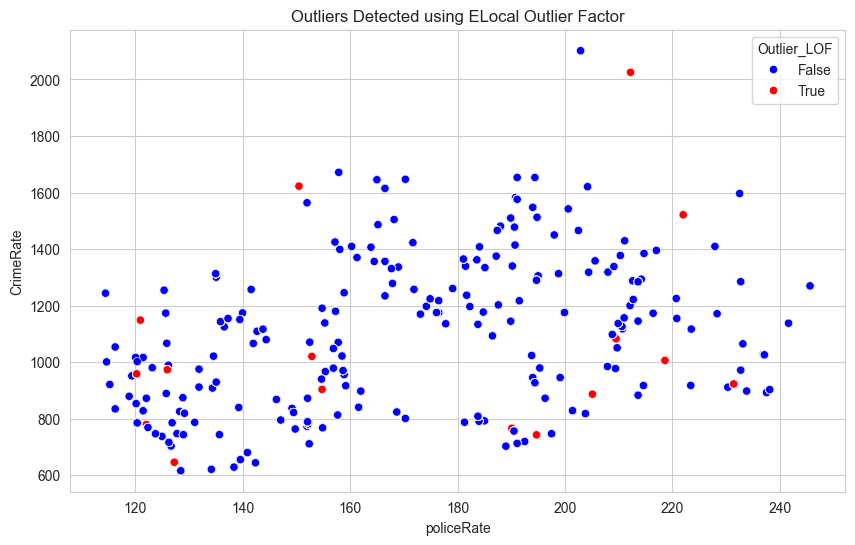

In [17]:
# Outlier removal and Standardization

# Select relevant numeric features
features = ["CrimeRate", "UnemploymentRate", "lowIncImmobRate",'infAdjInc','policeRate']
X = df[features].dropna()

# Method 1: Distance using Elliptic Envelope
ee = EllipticEnvelope(contamination=0.05)
X["Outlier_EllipticEnvelope"] = ee.fit_predict(X)

# Method 2: Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
X["Outlier_IsoForest"] = iso_forest.fit_predict(X)

# Method 3: Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=40, contamination=0.05)
X["Outlier_LOF"] = lof.fit_predict(X)

# Identify outliers
outliers = X[(X["Outlier_EllipticEnvelope"] == -1) | 
              (X["Outlier_IsoForest"] == -1) | 
              (X["Outlier_LOF"] == -1)]

df = df[~df.index.isin(outliers.index)]
print("Number Multivariate Outliers Detected:")
print(outliers[["CrimeRate", "UnemploymentRate", "infAdjInc"]].shape[0])

# Visualizing Local Outlier
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X, x="policeRate", y="CrimeRate", hue=(X["Outlier_LOF"] == -1), palette={True: "red", False: "blue"})
plt.title("Outliers Detected using ELocal Outlier Factor")
plt.show()

# Standardizing variables
num_cols = df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
dfStand = df.copy()
dfStand.drop(columns=['Year'])
dfStand[num_cols] = scaler.fit_transform(df[num_cols])
dfStand["Year"] = df["Year"]

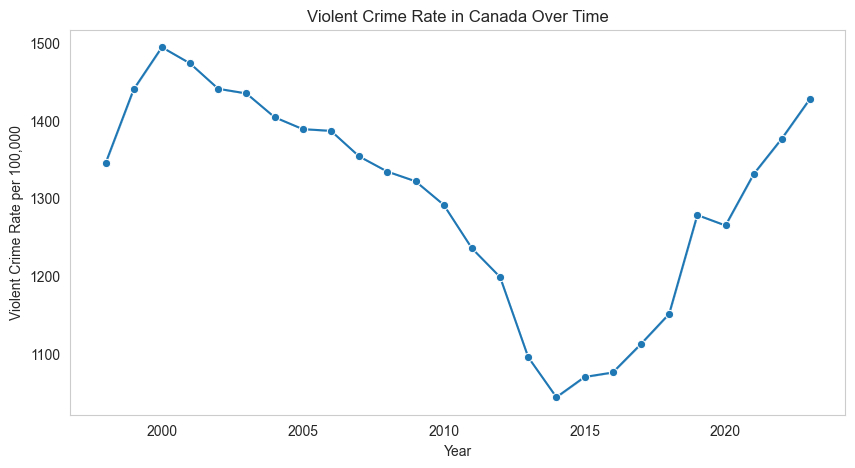

In [10]:
# Plot Crime Rate Over Time for Canada
df_canada = df[df["City"] == "Canada"]
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_canada, x="Year", y="CrimeRate", marker="o")
plt.title("Violent Crime Rate in Canada Over Time")
plt.ylabel("Violent Crime Rate per 100,000")
plt.xlabel("Year")
plt.grid()
plt.show()

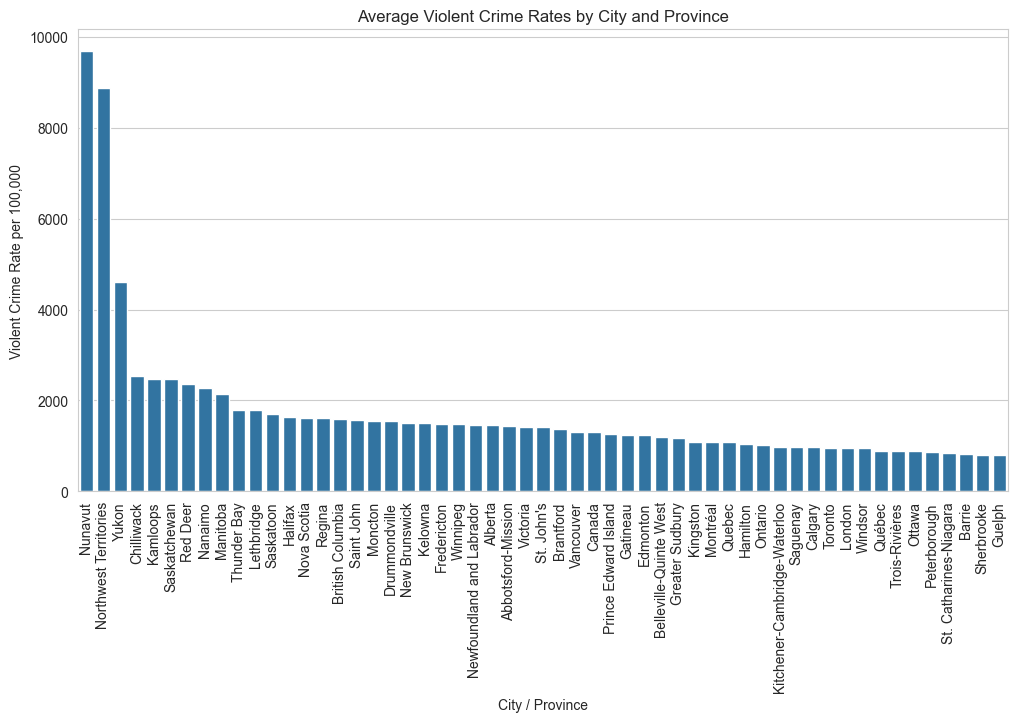

In [11]:
# Compare average Crime Rates in all years across Cities
df_avg = df.groupby("City")["CrimeRate"].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_avg, x="City", y="CrimeRate", order=df_avg.sort_values("CrimeRate", ascending=False)["City"])
plt.xticks(rotation=90)
plt.title("Average Violent Crime Rates by City and Province")
plt.ylabel("Violent Crime Rate per 100,000")
plt.xlabel("City / Province")
plt.show()

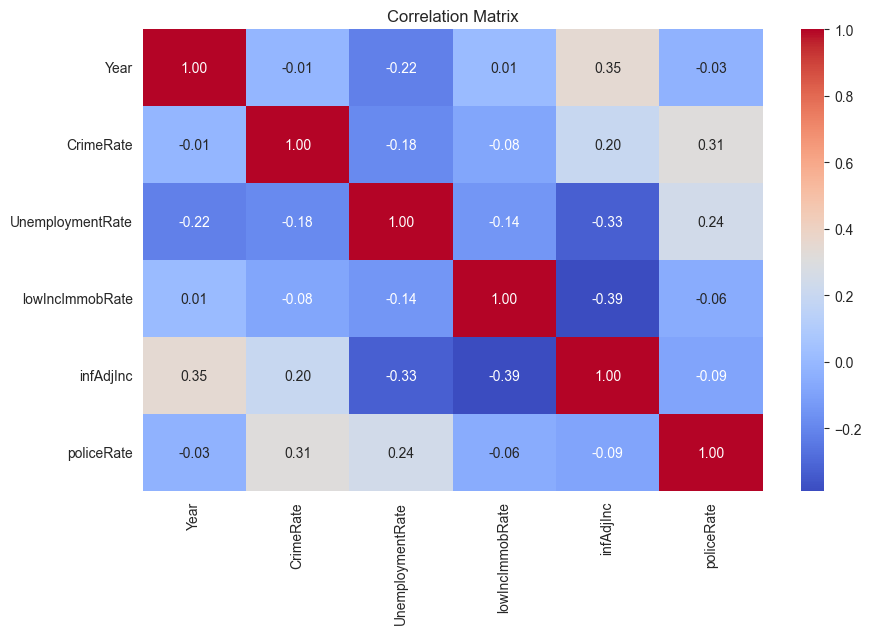

In [12]:
# Correlation Matrix

plt.figure(figsize=(10, 6))
sns.heatmap(dfStand.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

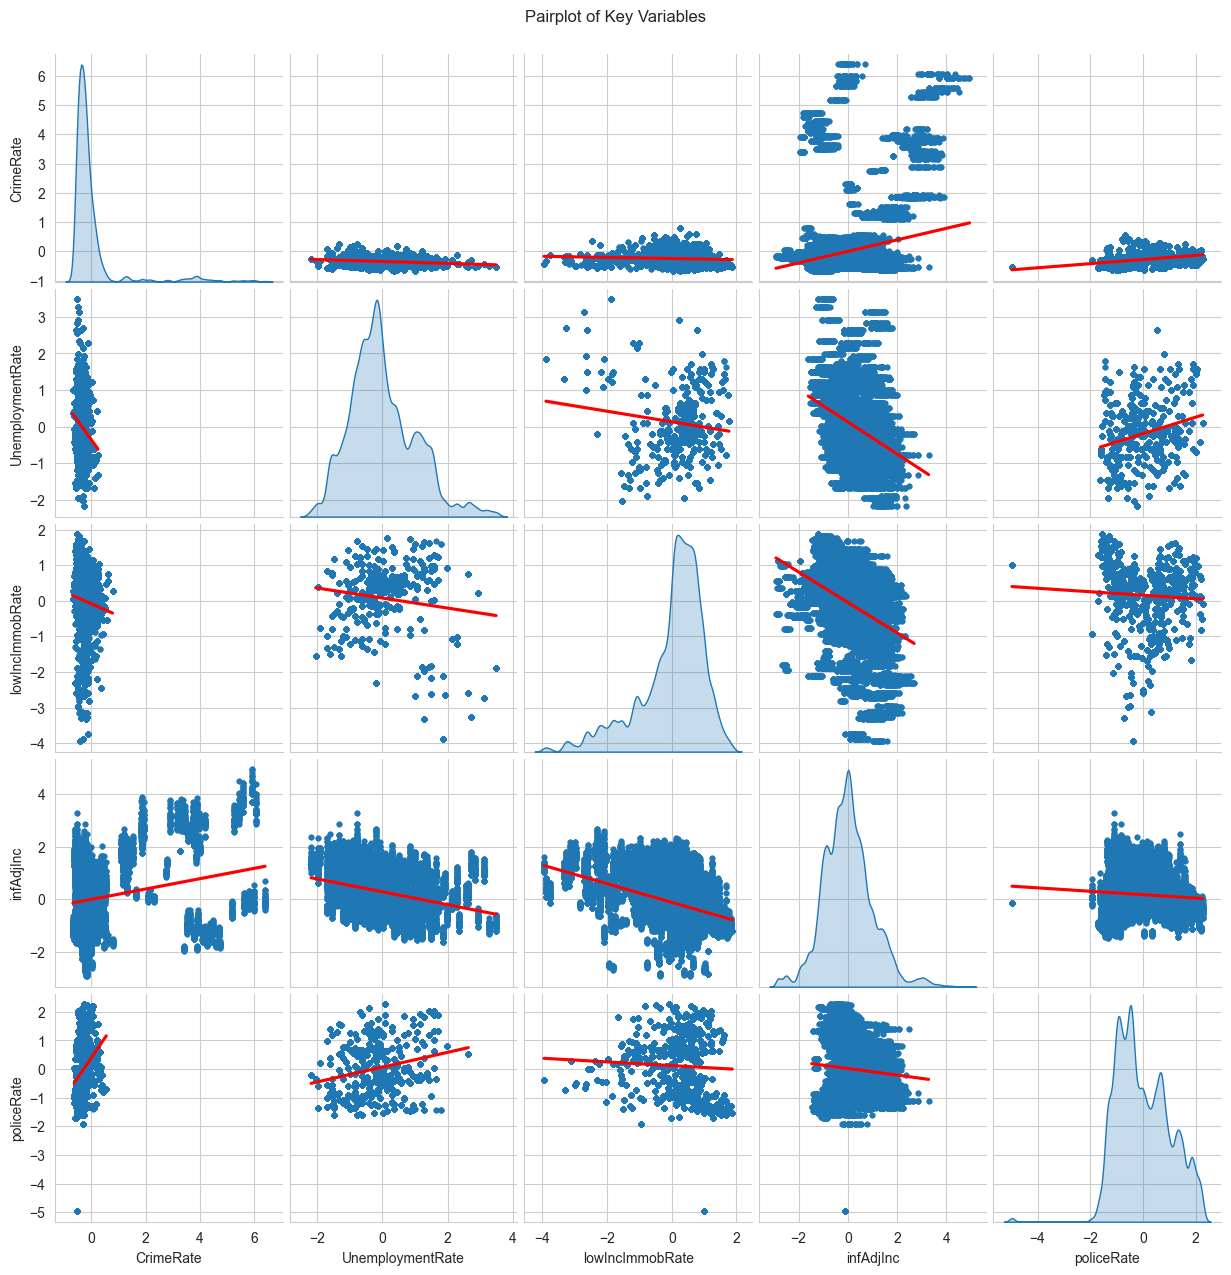

In [13]:
# Standardized pairplot
sns.set_style("whitegrid")
pairplot = sns.pairplot(dfStand, vars=["CrimeRate", "UnemploymentRate", "lowIncImmobRate",'infAdjInc','policeRate'], 
                        kind="reg", diag_kind="kde", markers="o",
                        plot_kws={"scatter_kws": {"alpha": 0.5, "s": 10}, "line_kws": {"color": "red"}})
pairplot.fig.suptitle("Pairplot of Key Variables", y=1.02)
plt.show()

Running model training and evaluation...

Linear Regression: RMSE = 0.1280

Ridge Regression: RMSE = 0.1280

Lasso Regression: RMSE = 0.1498

Tuning Random Forest...
Best params for Random Forest: {'max_depth': None, 'n_estimators': 50}
Random Forest: RMSE = 0.0012

Tuning Gradient Boosting...
Best params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Gradient Boosting: RMSE = 0.0337

Tuning Support Vector Regression...
Best params for Support Vector Regression: {'C': 1.0, 'gamma': 1, 'kernel': 'rbf'}
Support Vector Regression: RMSE = 0.0710

Tuning k-Nearest Neighbors...
Best params for k-Nearest Neighbors: {'n_neighbors': 3}
k-Nearest Neighbors: RMSE = 0.0017

AdaBoost: RMSE = 0.0910

Bagging: RMSE = 0.0012

Stacking Ensemble: RMSE = 0.0136



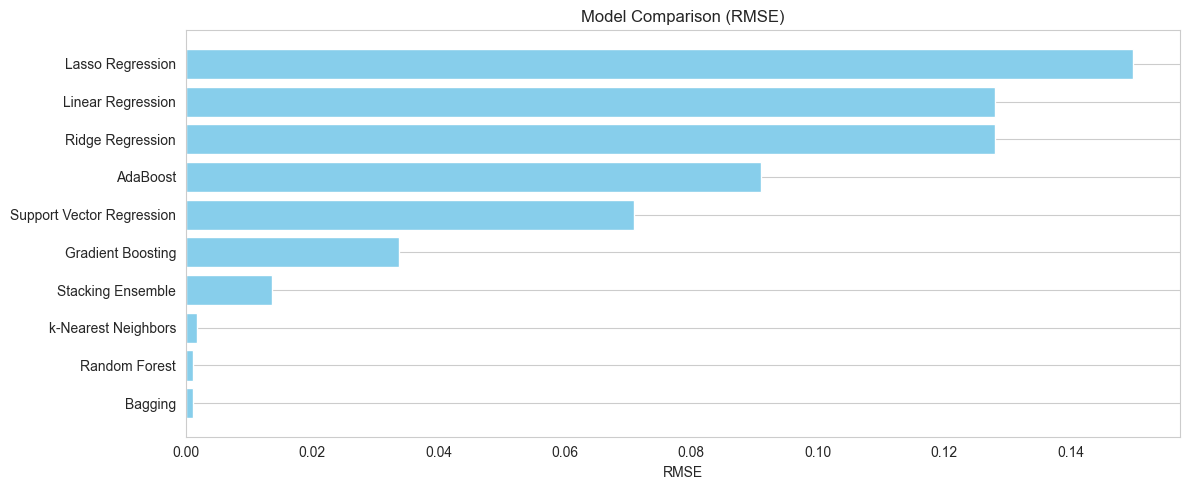

In [16]:
# Predictive modeling with train-test split
X_model = dfStand[["UnemploymentRate", "lowIncImmobRate", "infAdjInc",'policeRate']].dropna()
y = dfStand.loc[X_model.index, "CrimeRate"]
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=42)

# Grid search hyperparameters
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100],
        "max_depth": [None, 10, 20]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5]
    },
    "k-Nearest Neighbors": {
        "n_neighbors": [3, 5, 7]
    },
    "Support Vector Regression": {
        "C": [0.1, 1.0, 10.0],
        "gamma": [0.01, 0.1, 1],
        "kernel": ['rbf']
    }
}

# Base models
base_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "k-Nearest Neighbors": KNeighborsRegressor(),
    "AdaBoost": AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4), n_estimators=100, random_state=42),
    "Bagging": BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42),
    "Stacking Ensemble": StackingRegressor(
        estimators=[
            ('svr', SVR(C= 10.0, epsilon= 0.1, gamma= 0.01, kernel= 'rbf')),
            ('rf', RandomForestRegressor(max_depth = 10, n_estimators = 100, random_state=42)),
            ('knn', KNeighborsRegressor(n_neighbors = 5))
        ],
        final_estimator=GradientBoostingRegressor(learning_rate = 0.05, max_depth = 3, n_estimators = 50, random_state=42),
        cv=5
    )
}

# Final models (with tuned versions if available)
final_models = {}
rmse_results = {}

print("Running model training and evaluation...\n")

# Tune hyperparams if needed
for name, model in base_models.items():
    if name in param_grids:
        print(f"Tuning {name}...")
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"Best params for {name}: {grid.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_model = model

    final_models[name] = best_model
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_results[name] = rmse
    print(f"{name}: RMSE = {rmse:.4f}\n")

# Collect performance metrics
model_names = list(rmse_results.keys())
rmses = list(rmse_results.values())

# Sort by RMSE for better visualization
sorted_indices = np.argsort(rmses)
model_names_sorted = [model_names[i] for i in sorted_indices]
rmses_sorted = [rmses[i] for i in sorted_indices]

# Plot RMSE
plt.figure(figsize=(12, 5))
plt.barh(model_names_sorted, rmses_sorted, color='skyblue')
plt.xlabel("RMSE")
plt.title("Model Comparison (RMSE)")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Model Selection
After training and evaluating multiple regression models, ensemble and tree-based methods demonstrated the strongest predictive performance. Bagging, Random Forest and knn models excel at capturing non-linear relationships and interactions among features, which likely explains their superior performance compared to linear models. Stacking Ensemble, gradiant boosting and Support vectors also performed well. In contrast, simpler models such as Linear Regression and Ridge Regression produced a lower RMSE values indicating they may struggle to capture the underlying complexity in the data. Lasso Regression performed worst overall, likely due to its aggressive regularization, which may have excluded informative features. Overall, these results highlight the advantage of flexible, non-linear models in capturing nuanced patterns in the data.